<a href="https://colab.research.google.com/github/slisnychyi/SergiiLisnychyiZPI_zp01Lab1_PIIS/blob/main/Neuronetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KPI - Лісничий Сергій

# група - ЗПІ-зп01
# Програмування інтелектуальних інформаційних систем 

### Прогнозування ціни будинку в залежності від параметрів(розмір його площі) з використання тренування, верифікації нейромережі




In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.9.2


**Підготовка данних**


Ми будемо використовувати датасет - Ames dataset, що є стандартним датасетом використовуваним для прогнозування ціни будинку в залежності від його характеристик. 

Була скачана частина даних за один місяць. 05-2010.csv

In [5]:
from google.colab import files

uploaded = files.upload()

csv_hoesfile = next(iter(uploaded.keys()))

print('User uploaded file "{name}" with length {length} bytes.'.format(name=csv_hoesfile, length=len(uploaded[csv_hoesfile])))

Saving AmesHousing-05-2010.csv to AmesHousing-05-2010.csv
User uploaded file "AmesHousing-05-2010.csv" with length 20140 bytes.


Завнтажити дані в pandas dataframe для аналізу

In [6]:
import pandas as pd

# завантажуємо файл в Пандас
df_housing = pd.read_csv(csv_hoesfile)

Візуалізуємо дані

In [7]:
# Виставляємо видимими всі колонки, в іншому випадку деякі можуть буіи не видимі
pd.set_option('display.max_columns', None)

# демонстрація перши 5 колонок
df_housing.head(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639,Unf,0,441,1080,GasA,Fa,Y,SBrkr,1656,0,0,1656,1,0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2,528,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,13,527166040,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,789,789,GasA,Gd,Y,SBrkr,789,676,0,1465,0,0,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998.0,Fin,2,393,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,180400
2,38,528112020,20,RL,98.0,11478,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2007,2008,Gable,CompShg,VinylSd,VinylSd,Stone,200.0,Gd,TA,PConc,Ex,TA,No,GLQ,1218,Unf,0,486,1704,GasA,Ex,Y,SBrkr,1704,0,0,1704,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2008.0,RFn,3,772,TA,TA,Y,0,50,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,306000
3,56,528240070,60,RL,NaN,7851,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,216500
4,59,528292020,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2001,2001,Gable,CompShg,VinylSd,VinylSd,BrkFace,180.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,884,884,GasA,Ex,Y,SBrkr,884,1151,0,2035,0,0,2,1,3,1,Gd,8,Typ,1,Gd,BuiltIn,2001.0,Fin,2,434,TA,TA,Y,144,48,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,222500


Але немає колонки з загальним розміром будинку. Тому створимо таку.

На основі розміру підвалу 'Total Bsmt SF' та загальна жила площа \'Gr Liv Are'

In [8]:
# Перевіряємо чи немає null в колонках які будемо агрегувати
df_housing[['Total Bsmt SF', 'Gr Liv Area']].isnull().values.any()
# Додаємо нову колонку для агрегації розміру
df_housing['Total SF'] = df_housing['Total Bsmt SF'] + df_housing['Gr Liv Area']

print(df_housing[['Total SF','Total Bsmt SF','Gr Liv Area', 'SalePrice']].head(5))

   Total SF  Total Bsmt SF  Gr Liv Area  SalePrice
0      2736           1080         1656     215000
1      2254            789         1465     180400
2      3408           1704         1704     306000
3      2820            860         1960     216500
4      2919            884         2035     222500


Використаємо бібліотеку `matplotlib` для того, щоб візуалізувати наші дані.
Щоб дати нам відображення відношення ціни до розміру будинку.

In [9]:
def visualize_data(x_vals, y_vals,
                   addn_x_vals=None, addn_y_vals=None, add_addn_reg_line=False):
  f, ax = plt.subplots(figsize=(8,8))
  plt.plot(x_vals, y_vals, 'ro') # червоні точки для кожного елементу даних
  if(addn_x_vals is not None):
    plt.plot(addn_x_vals, addn_y_vals, 'g^') # зелені трикутники для додаткових даних
    # додатково зобразиму лінію регресії 
    if(add_addn_reg_line):
      x_min_index = addn_x_vals.argmin()
      x_max_index = addn_x_vals.argmax()
      print(x_min_index,[addn_x_vals[x_min_index],addn_y_vals[x_min_index]])
      print(x_max_index,[addn_x_vals[x_max_index],addn_y_vals[x_max_index]])
      plt.plot([addn_x_vals[x_min_index],addn_y_vals[x_min_index]],
               [addn_x_vals[x_max_index],addn_y_vals[x_max_index]],
               'b-') # малює блакитну лінію регресії
  plt.tick_params(axis='both', which='major', labelsize=14)

  plt.show() # малюємо лінію та відображамо дані

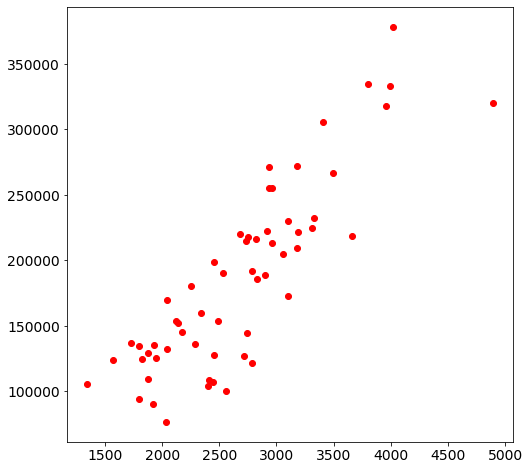

In [10]:
visualize_data(df_housing['Total SF'], df_housing['SalePrice'])

Ми бачимо лінійну залежність між ціною та розміром. y = mx + b
Price = m * square fet + b

Як бачимо наші дані різного масштабу і буде важко model визначити залежність між ціною та розміром. Тому треба нормалізувати ці дані.

Тепер необхідно нормальзувати значення SF та Price до нормалізованого маштабу (scale).

Зазвичай це значення від 0 до 1

In [14]:
from sklearn.preprocessing import MinMaxScaler

sf_scaler = MinMaxScaler()
sf_scaled = sf_scaler.fit_transform(df_housing['Total SF'].values.reshape(-1,1).astype(np.float64))

price_scaler = MinMaxScaler()
price_scaled = price_scaler.fit_transform(df_housing['SalePrice'].values.reshape(-1,1)).astype(np.float64)

**Створюємо модель**

Для створення моделі нейромережі, будемо використовувати високорівненву бібліотеку Keras. 
Нейромережа складається з нейронів. Створємо такий нейрон.

In [11]:
# Створюємо модель використовуючи TensorFlow Keras library

model = tf.keras.Sequential() # модель, що складається з послідовних нейронів
model.add(tf.keras.layers.Dense(units=1, activation='linear', input_shape=(1,),
                                kernel_initializer='random_uniform',
                                bias_initializer='zeros')) # ми створюємо Dense layer - де кожин вхід(SF-square footage) відповідає виходу(Price)

**Компілюємо модель**

Після створення моедлі нам необхідно її підготувати для тренування.

Тренування моделі відбувається шляхом передачі тренувальниї даних і змінючи `weight` та `bias`, щоб зменшити loss (error).

Щоб цього досягти нам потрібний метод, який оцінює loss та оптимізує `weight` та `bias`, щоб зменшити loss. 

y = wx + b

Ми будемо використовувати `Mean-Squared Error` для оцінки loss та Stochastic Gradient Descent ('sdg'), щоб знайти оптимальні показники `weight` та `bias`, щоб зменшити loss.



In [12]:
optimizer = "sgd" 
model.compile(loss='mean_squared_error', optimizer=optimizer)

**Тренуємо модель**

Ми тренуємо модель за допомогою тренувальних даних.

**Розділемо наші дані** на - training, testing. 70:30
ми не маємо икористоувати testing дані для тренування

In [15]:
from sklearn.model_selection import train_test_split

sf_train_scaled, sf_test_scaled, price_train_scaled, price_test_scaled = train_test_split(sf_scaled,
                                                                                          price_scaled,
                                                                                          test_size=0.3, random_state=42)

**Тренуємо модель** використовуючи розподілені дані.

Ми передаємо дані в модель декілька разів, на кожному разі loss ф-ія (яку ми створили на єтапі компілювання) буде використана для розрахунку loss.

І `optimizer` буде використаний, щоб робити підлаштування `weight` та `bias` для мінімізації цього error.

:epochs - к-ть разів optimizier буде йти по тренувальним даним щоб зменшити loss

:verbose - у-ть інформації показувати протягом процесу тренування (0 - нічого, 1,2 - показувати)


In [16]:
initial_epochs = 8
batch_size = 10
train_hist = model.fit(sf_train_scaled, price_train_scaled,
                       epochs=initial_epochs, batch_size=batch_size, verbose=1)

Epoch 1/8
5/5 [==============================] - 2s 4ms/step - loss: 0.2038
Epoch 2/8
5/5 [==============================] - 0s 3ms/step - loss: 0.1636
Epoch 3/8
5/5 [==============================] - 0s 10ms/step - loss: 0.1360
Epoch 4/8
5/5 [==============================] - 0s 6ms/step - loss: 0.1206
Epoch 5/8
5/5 [==============================] - 0s 7ms/step - loss: 0.1062
Epoch 6/8
5/5 [==============================] - 0s 5ms/step - loss: 0.0911
Epoch 7/8
5/5 [==============================] - 0s 4ms/step - loss: 0.0820
Epoch 8/8
5/5 [==============================] - 0s 4ms/step - loss: 0.0746


**Візуальне відображення тренованої моделі**

Посля тренування наша модель визначила кращі значення для `weight` та `bias`. Давайте подивимось як візуально це виглядатиме

2/2 [==============================] - 0s 7ms/step


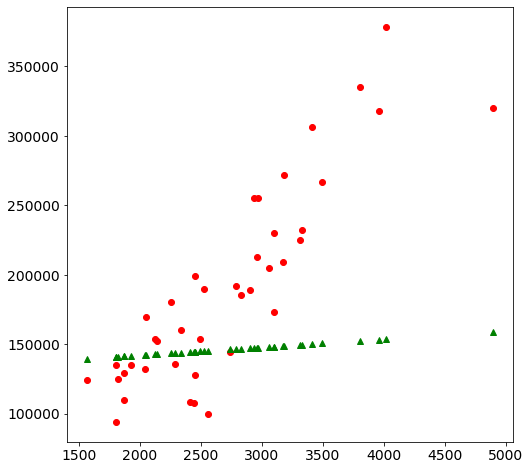

In [17]:
# Передбачимо ціну на основі нашої натренованої моделі
price_predicted_scaled = model.predict(sf_train_scaled) # повертаємо список передбачених цін
visualize_data(sf_scaler.inverse_transform(sf_train_scaled), price_scaler.inverse_transform(price_train_scaled),
               sf_scaler.inverse_transform(sf_train_scaled), price_scaler.inverse_transform(price_predicted_scaled),
               add_addn_reg_line=False)

Для покращення моделі перебачення натренуємо нашу модель більшу к-ть разів

In [18]:
addn_epochs = 1200
train_hist_addn = model.fit(sf_train_scaled, price_train_scaled,
                       epochs=addn_epochs, batch_size=batch_size, verbose=1)

Epoch 1/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0695
Epoch 2/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0631
Epoch 3/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0583
Epoch 4/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0544
Epoch 5/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0507
Epoch 6/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0495
Epoch 7/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0475
Epoch 8/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0467
Epoch 9/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0460
Epoch 10/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0451
Epoch 11/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0448
Epoch 12/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0442
Epoch 13/1200
5/5 [==============================

2/2 [==============================] - 0s 3ms/step


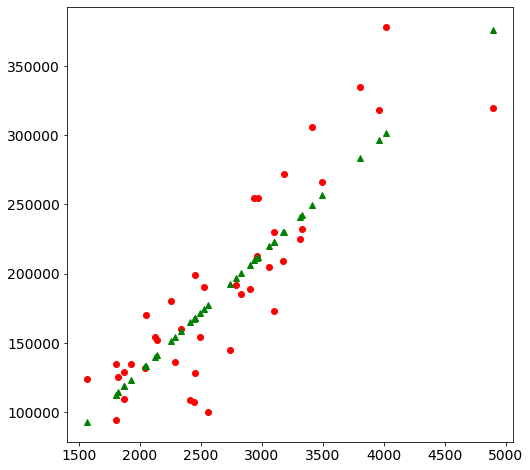

In [19]:
price_predicted_scaled = model.predict(sf_train_scaled) # повертаємо список передбачених цін
visualize_data(sf_scaler.inverse_transform(sf_train_scaled), price_scaler.inverse_transform(price_train_scaled),
               sf_scaler.inverse_transform(sf_train_scaled), price_scaler.inverse_transform(price_predicted_scaled),
               add_addn_reg_line=False)

**Перевірка нашої моделі з тестовими даними**

Після того як ми отримали коректну натреновану модельm ми хочемо перевірити її якість з тестовими даними.


1/1 [==============================] - 0s 16ms/step
prediction mean squared error: 0.018254219072065443


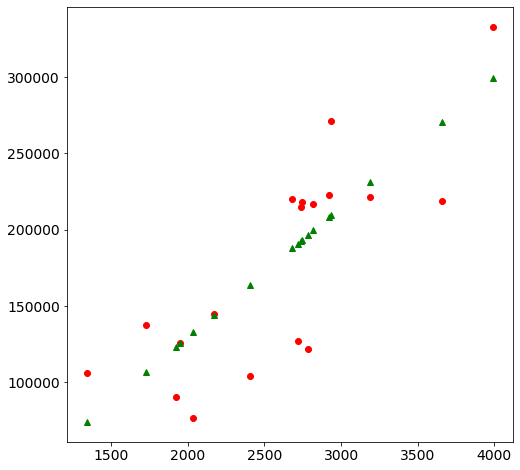

In [20]:
from numpy.ma.core import mean
# Зробимо передмачення ціна на тестових даних, які модель раніше не бачила
price_test_pred_scaled = model.predict(sf_test_scaled)

# Розрахуємо mean squared error for the prediction, чим менше тим краще
from sklearn.metrics import mean_squared_error

print("prediction mean squared error:",
      mean_squared_error(price_test_scaled, price_test_pred_scaled))

# візуалізуємо передбачені дані ціни зеленим, а тестові дані червоним
visualize_data(sf_scaler.inverse_transform(sf_test_scaled),
               price_scaler.inverse_transform(price_test_scaled),
               sf_scaler.inverse_transform(sf_test_scaled),
               price_scaler.inverse_transform(price_test_pred_scaled),
               add_addn_reg_line=False)